# Project: Dataset Augmentation Using GANs
##  Getting Started

###  Import the Libraries

In [2]:
import time
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython import display
%matplotlib inline

### Task 2: Create the Data
#### Create dataset

In [3]:
X = torch.normal(0.0, 1, (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b

#### Display dataset

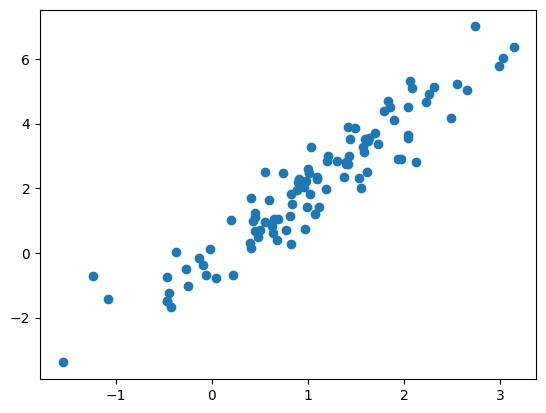

In [4]:
plt.scatter(data[:100, 0].detach().numpy(), data[:100, 1].detach().numpy())

#### Creating Dataset Iterateables

In [5]:
batch_size = 8
dataset = torch.utils.data.TensorDataset(data)
data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

##  The Model
###  Generators and Discriminators

#### Generator Neural Net

In [6]:
nnet_Gen = nn.Sequential(nn.Linear(2, 2))

#### Discriminator Neural Net

In [7]:
nnet_Disc = nn.Sequential(
  nn.Linear(2, 5), nn.Tanh(),
  nn.Linear(5, 3), nn.Tanh(),
  nn.Linear(3, 1))

### Discriminator Updates

In [8]:
def update_D(X, Z, nnet_D, nnet_G, loss, trainer_D):
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad()
    real_Y = nnet_D(X)
    synth_X = nnet_G(Z)
    synth_Y = nnet_D(synth_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) +
              loss(synth_Y, zeros.reshape(synth_Y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D

###  Generator Updates

In [9]:
def update_G(Z, nnet_D, nnet_G, loss, trainer_G):
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    synth_X = nnet_G(Z)
    synth_Y = nnet_D(synth_X)
    loss_G = loss(synth_Y, ones.reshape(synth_Y.shape))
    loss_G.backward()
    trainer_G.step()
    return loss_G

##  The Train Function
### Initialize the Parameters

In [10]:
def init_params(Discriminator, Generator, lr_D, lr_G):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in Discriminator.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in Generator.parameters():
        nn.init.normal_(w, 0, 0.02)
    trainer_D = torch.optim.Adam(Discriminator.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(Generator.parameters(), lr=lr_G)
    fig, axes = plt.subplots(2, 1, figsize=(5, 9))
    loss_D = []
    loss_G = []

    return loss, trainer_D, trainer_G, fig, axes, loss_D, loss_G

### Compute the Losses

In [11]:
def compute_losses(X, net_D, net_G, loss, trainer_D, trainer_G, batch_size, latent_dim, data_iter):
    metrics = [0.0]*3 
    for (X,) in data_iter:
        batch_size = X.shape[0]
        Z = torch.normal(0, 1, size=(batch_size, latent_dim))
        metric = [update_D(X, Z, net_D, net_G, loss, trainer_D),
                    update_G(Z, net_D, net_G, loss, trainer_G),
                    batch_size]
        metrics = [sum(i) for i in zip(metric, metrics)]

    return metrics

### Display Generated Distributions

In [12]:
def display_gen_dist(net_G, axes, latent_dim, data):
    Z = torch.normal(0, 1, size=(100, latent_dim))
    synth_X = net_G(Z).detach().numpy()
    axes[1].cla()
    axes[1].scatter(data[:, 0], data[:, 1])
    axes[1].scatter(synth_X[:, 0], synth_X[:, 1])
    axes[1].legend(['real', 'generated'])

### Display the losses

In [13]:
def display_losses(metrics, loss_D, loss_G, axes, fig, epoch):
    D = metrics[0]/metrics[2]
    loss_D.append(D.detach())
    G = metrics[1]/metrics[2]
    loss_G.append(G.detach())
    axes[0].plot(range(epoch+1), loss_D, c="blue")
    axes[0].plot(range(epoch+1), loss_G, c="green")
    axes[0].legend(['Discriminator loss', 'Generator loss'])
    display.display(fig)
    display.clear_output(wait=True)

    return loss_D, loss_G

### Create the Training Function

In [14]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    # Start timer
    tik = time.perf_counter()
    # Init variables
    loss, trainer_D, trainer_G, fig, axes, loss_D, loss_G = init_params(net_D, net_G, lr_D, lr_G)
    for epoch in range(num_epochs):
        # Train one epoch
        metrics = compute_losses(X, net_D, net_G, loss, trainer_D, trainer_G, batch_size, latent_dim, data_iter)
        # Visualize generated examples
        display_gen_dist(net_G, axes, latent_dim, data)
        # Show the losses
        loss_D, loss_G = display_losses(metrics, loss_D, loss_G, axes, fig, epoch)
    # End timer
    tok = time.perf_counter()
    # Display stats
    print(f'loss_D {loss_D[-1]}, loss_G {loss_G[-1]}, {(metrics[2]*num_epochs) / (tok-tik):.1f} examples/sec')

#### Train the Model

loss_D 0.6931558847427368, loss_G 0.693122386932373, 1558.6 examples/sec


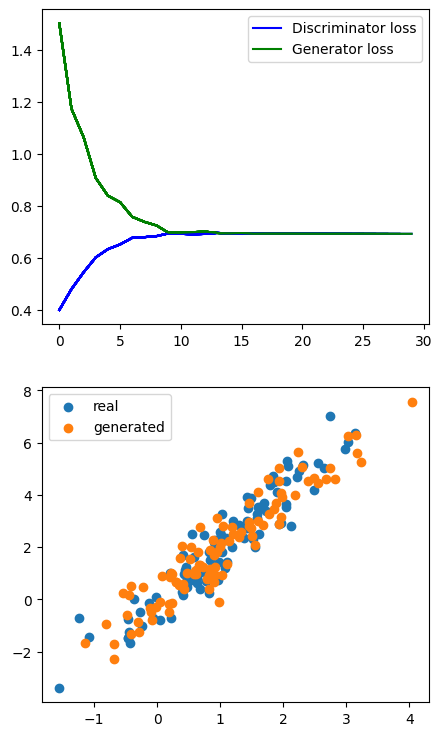

In [15]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 30
train(nnet_Disc, nnet_Gen, data_iter, num_epochs, lr_D, lr_G, latent_dim, data[:100].detach().numpy())

# End